In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from scipy import stats

In [2]:
from transformers import AutoTokenizer, AutoModel
from bert_transformer import BertTransformer

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [3]:
X_string = 'nlp_3', 'nlp_2', 'nlp_5', 'nlp_4' # TUPLE
Y_string = 'GDT_score'
DATASET = 'NLP_FULLSTOPS.xlsx'

In [4]:
df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df.reset_index()

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [5]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

y = df[Y_string]
X.shape


nlp_4 added to list


(502, 3072)

In [6]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

pilot_X = []

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_Y = pilot_df[Y_string]
pilot_X.shape

nlp_4 added to list


(95, 3072)

In [7]:
learning_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.96)

In [86]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error


kfold = KFold(n_splits=10, shuffle=True, random_state=1)

true_data = []
results = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(X_train.shape)
    model = tf.keras.Sequential([
                            # tf.keras.layers.LSTM(64, input_shape=(3072, 1)),
                            # tf.keras.layers.Conv1D(32, (3,), activation='relu', input_shape=(3072, 1)),
                            # tf.keras.layers.Dropout(0.5),
                            # tf.keras.layers.MaxPooling1D(),
                            # tf.keras.layers.Flatten(),
                            # tf.keras.layers.Conv1D(32, (3,), activation='relu', input_shape=(3072, 1)),
                            tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(units=1)
                            ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='mean_absolute_error')

    model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0)
    result = model.predict(X_test)

    result = [float(item) for item in result]
    results = np.concatenate((results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))
    print(stats.pearsonr(results, true_data))
    print(mean_absolute_error(result, y_test))
    print(mean_absolute_error(results, true_data))

(451, 3072)
2/2 [==============================] - 0s 9ms/step
PearsonRResult(statistic=0.41431137727627015, pvalue=0.0025067124996519616)
PearsonRResult(statistic=0.41431137727627015, pvalue=0.0025067124996519616)
2.324131806691488
2.324131806691488
(451, 3072)
2/2 [==============================] - 0s 3ms/step
PearsonRResult(statistic=0.5024638924803491, pvalue=0.00017179869254930745)
PearsonRResult(statistic=0.4585295192972527, pvalue=1.2566949445975168e-06)
2.706684823129691
2.5154083149105895
(452, 3072)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.2935900419754968, pvalue=0.0385148247658627)
PearsonRResult(statistic=0.38925967524181726, pvalue=7.180881241552112e-07)
2.9261282873153687
2.650513568991109
(452, 3072)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.4740589540664293, pvalue=0.0005057568703625427)
PearsonRResult(statistic=0.3953495827671598, pvalue=5.7771840817704755e-09)
2.3129340553283693
2.56695428343102

In [87]:
#WHOLE DATASET

results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, true_data))

PearsonRResult(statistic=0.3654007289962986, pvalue=2.654294129338213e-17)


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(true_data, results)
mse = mean_squared_error(true_data, results)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

MAE: 2.70
MSE: 12.57


In [89]:
answers_tuples = [(y, res) for y, res in zip(true_data, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

true_data = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

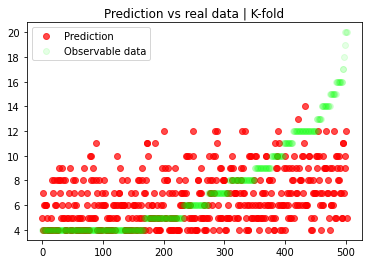

In [90]:
plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(true_data)), true_data, 'o', color=[0, 1, 0, 0.1], label='Observable data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | K-fold')
plt.show()

In [91]:
# Using model to predict pilot data

model = tf.keras.Sequential([
                        # tf.keras.layers.LSTM(64, input_shape=(None, 1)),
                        # tf.keras.layers.Conv1D(32, (3,), activation='relu', input_shape=(3072, 1)),
                        # tf.keras.layers.MaxPooling1D(),
                        # tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(units=1)
                        ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
model.fit(X, y, batch_size=64, epochs=100, verbose=0)

In [92]:
prediction = model.predict(pilot_X)
prediction = [float(item) for item in prediction]
pilot_results = [item if item >= 4 else 4 for item in prediction]
pilot_results = [item if item <= 20 else 20 for item in pilot_results]

print(stats.pearsonr(pilot_results, pilot_Y))

3/3 [==============================] - 0s 4ms/step
PearsonRResult(statistic=0.24862770007047216, pvalue=0.015118728331114597)


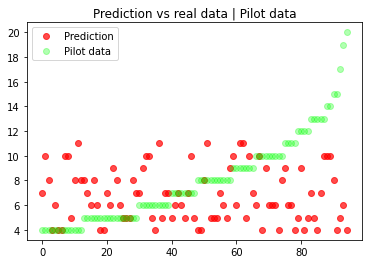

In [93]:
answers_tuples = [(y, res) for y, res in zip(pilot_Y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Pilot data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | Pilot data')
plt.show()